<a href="https://colab.research.google.com/github/kmualim/DCGAN-Keras-Implementation/blob/master/DCGAN_Keras_Implementation_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies 

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape 
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D 
from keras.layers import LeakyReLU, Dropout 
from keras.layers import BatchNormalization 
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal, Zeros
from keras.datasets import mnist
import matplotlib.pyplot as plt 
import sys 
import numpy as np

## Downloading Data: 

In [0]:
(x_train, y_train), (_,_) = mnist.load_data()


##To visualize the dataset: 

0


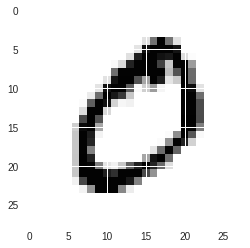

In [0]:
import matplotlib.pyplot as plt 
%matplotlib inline 
image_index=1
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')


#Training a GAN on MNIST dataset

Always gets the analogy of the counterfeiter and the police. Counterfeiter attempts to make new fake money on feedback from the police, until police is fooled by fake money generated. 

## The Discriminator v 1.0 (the police)

- essentially consists of a deep convolutional neural network
- differs from a typical CNN due to absence of max-pooling in between layers 
- downsampling is done through a strided convolution 
- Activation function and Dropout layers are used. 
- Dropout: 0.4 to 0.7 between layers prevents overfitting and memorization 

- reduced learning rate
- addition of dropout between layers 
- try changing parameters

##The Generator (the counterfeiter)

- synthesizes fake images generated from noise, using transposed convolution 
- upsampling between the first 3 layers used synthesizes more realistic handwriting images 
- Between-layer batch normalization stabilizes learning 
- Activation function and Dropout used. 
- Dropout of 0.3 to 0.5 usually used to prevent overfitting

## Discriminator Model v 2.0

In [0]:

class GAN(object): 
    def __init__(self):
      self.img_rows = 28 
      self.img_cols = 28 
      self.channel=1
      self.img_shape = (self.img_rows, self.img_cols, self.channel)
      
      optimizer = Adam(0.0002, 0.5)
     
    def build_discriminator(self):
      model = Sequential()
      depth = 32 
      dropout=0.25 
      input_shape = (self.img_rows, self.img_cols, self.channel)
      
      model.add(Conv2D(depth*1, 3, strides=2, input_shape=input_shape, padding='same'))#kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*2, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2))) #kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*4, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2)))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*8, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2)))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))

      # Each MNIST input = 28 X 28 X 1, depth = 1
      # Each Output = 14 X 14 X 1, depth = 64 
      # Model has 4 convolutional layer, each with a dropout layer in between 

      # Output 
      model.add(Flatten())
      model.add(Dense(1))
      model.add(Activation('sigmoid'))
      model.summary()
      
      img = Input(shape=(self.img_shape))
      validity = model(img)
      
      return Model(img, validity) 

    # generator takes noise as input and generates imgs
                
    def build_generator(self):
      generator = Sequential() 
      dropout = 0.4 
      depth = 128
      dim = 7

      # In: 100 
      # Out: dim X dim X depth 

      generator.add(Dense(dim*dim*depth, input_dim=100))
      generator.add(Activation('relu'))
      generator.add(Reshape((dim, dim, depth)))
      generator.add(UpSampling2D())
      #generator.add(Dropout(dropout))

      # In: dim X dim X depth
      # Out: 2*dim X 2*dim X depth/2 

      generator.add(Conv2D(depth, 3, padding='same'))#kernel_initializer='random_uniform', bias_initializer='zeros'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      generator.add(UpSampling2D())
      generator.add(Conv2D(int(depth/2), 3, padding='same'))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
     

      # Out : 28 X 28 X 1 grayscale image [0.0, 1.0] per pix
      generator.add(Conv2D(1,3,padding='same'))
      generator.add(Activation('tanh'))
      generator.summary()
      
      noise = Input(shape=(100,))
      img = generator(noise)
      
      return Model(noise, img)
    
    # Build and compile discriminator
    def DM(self):
      optimizer = Adam(0.0002, 0.5)
      DM = self.build_discriminator()
      DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      return DM    
    


## Updates: 
1. removing dropout from generator
2. removing weight initialization (why can this be removed? )
3. switched out conv2dTranspose with conv2D
4. optimizer used was Adam instead of RMSProp (I don't really see how this would change anything; but for some reason, there are specific tips on what optimizer to use)
5. 

In [0]:
class dcgan(object):
  def __init__(self): 
    self.img_rows=28
    self.img_cols=28
    self.channels=1
    
    
    # building the generator 
    self.GAN = GAN()
    self.DM = self.GAN.DM()
    self.generator = self.GAN.build_generator()
    
    
    z = Input(shape=(100,))
    img = self.generator(z)
    self.DM.trainable = False
    valid = self.DM(img)
    
    self.combined = Model(z, valid)
    optimizer = Adam(0.0002, 0.5)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # training input 
    (self.x_train, _), (_,_) = mnist.load_data()
    self.x_train = self.x_train/127.5 -1.
    self.x_train = np.expand_dims(self.x_train, axis=3) 
    self.n_samples = 25
    self.noise_dim = 100
  
  # method to generate noise 
  def gennoise(self,batch_size, noise_dim): 
    x = np.random.normal(0, 1.0, (batch_size, noise_dim))
    return x

  def plt_imgs(self,epoch): 
    noise = self.gennoise(25,100)
    fake_imgs = self.generator.predict(noise)
    fake_imgs = 0.5 * fake_imgs + 0.5
    
    fig,axs = plt.subplots(5,5)
    count = 0 
    for i in range(5): 
      for j in range(5): 
        axs[i,j].imshow(fake_imgs[count, :, :, 0], cmap='gray')
        axs[i,j].axis('off')
        count+=1
        
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()
    
    
  def train(self,n_epochs, batch_size):
    train_hist={}
    train_hist['D_losses']=[]
    train_hist['G_losses']=[]
    print("Start")
    true_labels=np.ones((batch_size,1))
    gen_gene_labels=np.zeros((batch_size,1))
    
    for epoch in range(n_epochs):
   
      index = np.random.randint(0, self.x_train.shape[0], batch_size)
      images = self.x_train[index]
      
      noise_data = self.gennoise(batch_size, 100)
      gen_imgs = self.generator.predict(noise_data)
      
      
      d_loss = self.DM.train_on_batch(images, true_labels)
    
      d_loss_generated = self.DM.train_on_batch(gen_imgs, gen_gene_labels)
      
      total_d_loss = 0.5 * np.add(d_loss, d_loss_generated)
      
      train_hist['D_losses'].append(total_d_loss[0])
        
      noise_data = self.gennoise(batch_size, 100)
      y1 = np.ones((batch_size, 1))    
      
      g_loss = self.combined.train_on_batch(noise_data, y1)

      train_hist['G_losses'].append(g_loss)
      print (' Epoch:{}, G_loss: {}, D_loss:{}'.format(epoch+1, g_loss, total_d_loss[0]))
      
      if epoch%50==0:
        self.plt_imgs(epoch)
      
    return train_hist
   
  def plotting_imgs(self,epoch): 
      noise = self.gennoise(25,100)
      fake_imgs = self.generator.predict(noise)
      fake_imgs = 0.5 * fake_imgs + 0.5
    
      fig,axs = plt.subplots(5,5)
      count = 0 
      for i in range(5): 
        for j in range(5): 
          axs[i,j].imshow(fake_imgs[count, :, :, 0], cmap='gray')
          axs[i,j].axis('off')
          count+=1
      
                                                                     
    
                                                                      

In [0]:
if __name__ == '__main__': 
  mnist_dcgan = dcgan()
  train_hist = mnist_dcgan.train(4000, batch_size=32)
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch:1, G_loss: 0.8602536916732788, D_loss:0.9269224405288696
 Epoch:2, G_loss: 0.865146279335022, D_loss:0.7572165727615356
 Epoch:3, G_loss: 0.971502423286438, D_loss:0.5803835391998291
 Epoch:4, G_loss: 1.2427204847335815, D_loss:0.5181673765182495
 Epoch:5, G_loss: 1.2580230236053467, D_loss:0.4848371148109436
 Epoch:6, G_loss: 1.5966047048568726, D_loss:0.342002272605896
 Epoch:7, G_loss: 1.4486751556396484, D_loss:0.3658806085586548
 Epoch:8, G_loss: 1.684565544128418, D_loss:0.3528187870979309
 Epoch:9, G_loss: 1.7376885414123535, D_loss:0.2862876057624817
 Epoch:10, G_loss: 2.145895004272461, D_loss:0.2808798849582672
 Epoch:11, G_loss: 1.6460716724395752, D_loss:0.26052325963974
 Epoch:12, G_loss: 1.6431703567504883, D_loss:0.28556814789772034
 Epoch:13, G_loss: 1.4571263790130615, D_loss:0.24497994780540466
 Epoch:14, G_loss: 1.4238524436950684, D_loss:0.2706400156021118
 Epoch:15, G_loss: 1.2185389995574951, D_loss:0.21408501267433167
 Epoch:16, G_loss: 1.1048251390457153,

## Images generated from generator 

@ Epoch 0 

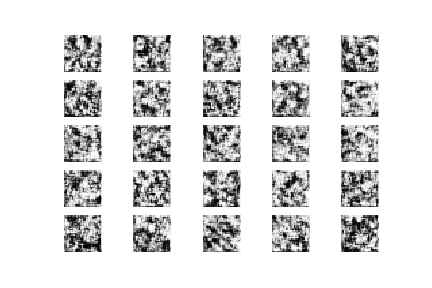

In [0]:
from IPython.display import Image, display
display(Image('mnist_0.png'))


@ Epoch 2000

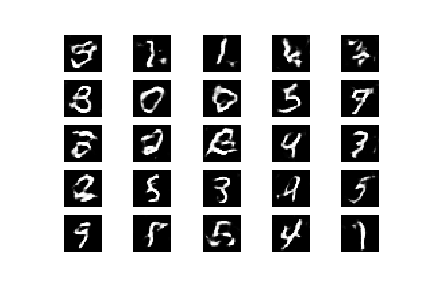

In [0]:
display(Image('mnist_2000.png'))

@ Epoch 3950

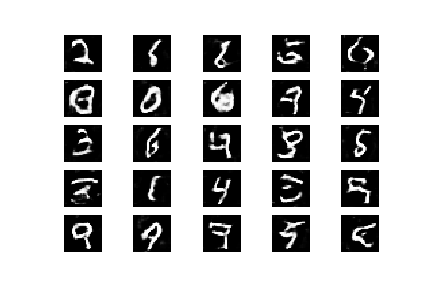

In [0]:
display(Image('mnist_3950.png'))

## Generating gif images 


In [0]:
import imageio
train_epoch=np.arange(0,4000,50)
images = []
for e in train_epoch:
    img_name = '/content/mnist_' + str(e) + '.png'
    imafrom IPython.display import Image, display
display(Image('1.png'))
display(Image('2.png'))ges.append(imageio.imread(img_name))
imageio.mimsave('/content/generation_animation.gif', images, fps=5)

## Data Visualization of Epoch v Loss 
- filled with many different attempts and adjustments to the model
- Epoch v Loss of the successful attempt is **Graph 6**

## Graph1: @ 2000 epochs, G loss increases up to 15 
- could be DCGAN collapse ?
- values reach 0 really quickly 

Text(0.5, 1.0, 'Number of Epoch v Loss')

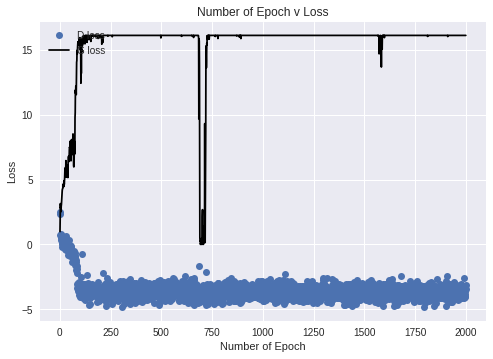

In [0]:
epoch=np.arange(1,2001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'o', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')


## Graph 2: @ Epoch 20; 

Text(0.5, 1.0, 'Number of Epoch v Loss')

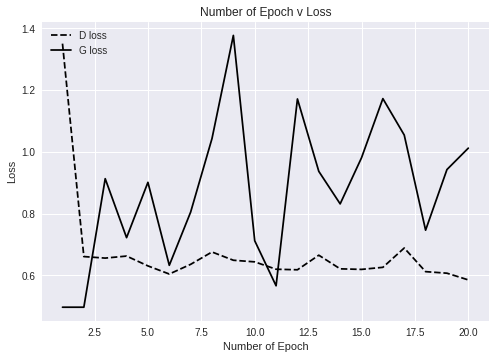

In [0]:
D_losses = [1.35, 0.660609, 0.65567153, 0.6622769, 0.630414009, 0.6041169762, 0.6354942321777, 0.6754931211471558, 0.6487343311309814, 0.643484354019165, 0.619666576385498, 0.617867648601532, 0.6650657057762146, 0.6209251880645752
           ,0.6191090941429138, 0.6258078813552856, 0.6882978081703186, 0.6118475198745728, 0.606818437576294, 0.5850663781166077]
G_losses = [0.4966937005519867,0.4966937005519867 ,0.9127594232559204,0.7218921780586243, 0.9009438753128052, 0.6323416233062744, 0.8046920895576477,1.042804479598999,1.3766385316848755,0.7118204832077026,0.5660661458969116, 1.1708855628967285, 0.9364973306655884,0.8312244415283203 , 0.9804545044898987, 1.1719845533370972
            ,1.0540974140167236,0.7460905313491821, 0.942375659942627, 1.0116865634918213]
epoch=np.arange(1,21,1)

fig, ax = plt.subplots()
ax.plot(epoch, D_losses, 'k--', label='D loss')
ax.plot(epoch, G_losses, 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')


## Graph 3: @ Epoch 2000 
- G loss 

Text(0.5, 1.0, 'Number of Epoch v Loss')

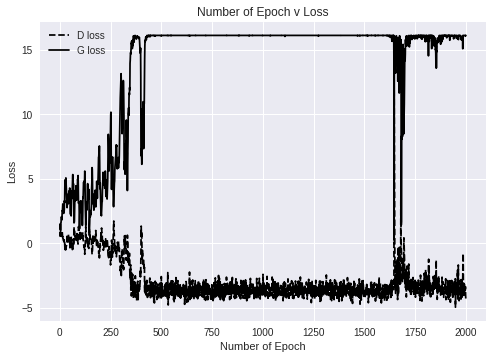

In [0]:
epoch=np.arange(1,2001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k--', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

## Graph4: @4000 epochs
- from 2000 to 4000 epochs, the images do look better but not completely discernable. 
- loss values are definitely alot more stable 

Text(0.5, 1.0, 'Number of Epoch v Loss')

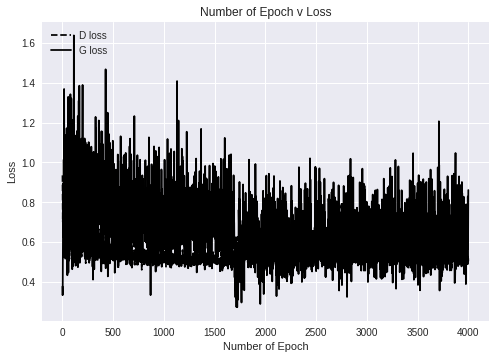

In [0]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k--', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Graph 5: @ epoch 4000 
- removed image flipping

Text(0.5, 1.0, 'Number of Epoch v Loss')

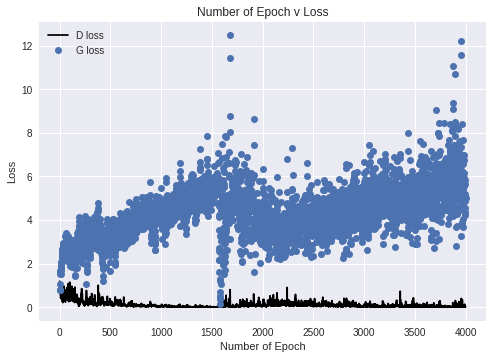

In [0]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k-', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'o', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Graph 6: SUCCESS! 
@ 4000 epochs 

- loss still fluctuates but the images look good! 

Text(0.5, 1.0, 'Number of Epoch v Loss')

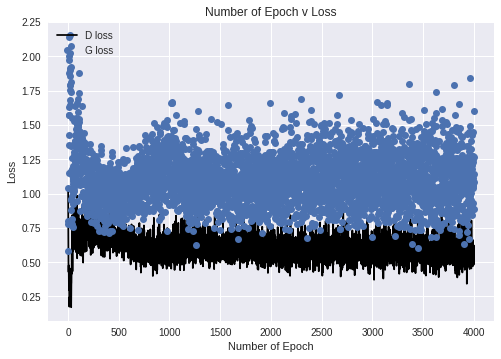

In [0]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k-', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'o', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Training the model
1.  first determine if discirminator model is correct by training it alone 
2. discriminator and adversarial models trained one after another 
3. train discriminator only for statistically significant values 